In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from models import SimpleNet, ConvNN
from util import model_param_to_1D, params_1d_to_weights, create_NN_with_weights

In [168]:
class SWAG:
    """ Implements the SWAG paper: https://arxiv.org/pdf/1902.02476.pdf
    """
    def __init__(self, NN_class, K):
        ''' Params:
                nn (): the NN on which Swag is performed
                K (int): maximum number of columns in deviation matrix
        '''

        # Neural Network related params
        self.NN_class = NN_class
        self.net = NN_class()
        self.params_1d, self.shape_lookup, self.len_lookup = model_param_to_1D(self.net)
        self.weigt_D = len(self.params_1d)

        # SWAG params
        self.K = K

    def init_storage(self):
        first_mom = np.zeros(self.weigt_D)
        second_mom = np.zeros(self.weigt_D)
        D = np.zeros((self.weigt_D, self.K))
        return first_mom, second_mom, D

    def net_step(self,
                 epoch: int,
                 train_mode: bool = False,
                 return_weights: bool = False):
        if not self.optimizer:
            raise RuntimeError("Please compile the model before training.")

        # Store and print running_loss
        running_loss = 0.0
        for i, data in enumerate(self.train_loader, 0):
            X_train, y_train = data
            self.optimizer.zero_grad()
            loss = self.loss_fn(self.net(X_train), y_train)
            loss.backward()
            self.optimizer.step()

            # Training mode
            if train_mode:
                self.train_scheduler.step()
            # Swag mode
            else:
                self.swa_scheduler.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

        # If return_weights
        if return_weights:
            new_weights, _, _ = model_param_to_1D(self.net)
            return new_weights

    def update_moments(self,
                       n: int,
                       first_mom: np.ndarray,
                       second_mom: np.ndarray,
                       new_weights: np.ndarray) -> (np.ndarray, np.ndarray):
        ''' Updates the momements storage vectors
            Params:
                n(int): number of models so far
                first_mom(np.ndarray): storage for first moment
                second_mom(np.ndarray): storage for second moment
                new_weights(np.ndarray): updated weights
            Output:
                first_mom_new(np.ndarray): updated first moment
                second_mom_new(np.ndarray): updated second moment
        '''
        second_mom_step = np.power(new_weights, 2)
        first_mom_new = (n*first_mom+new_weights) / (n+1)
        second_mom_new = (n*second_mom+second_mom_step) / (n+1)
        return first_mom_new, second_mom_new

    def update_D(self,
                 swag_step: int,
                 D: np.ndarray,
                 first_mom: np.ndarray,
                 new_weights: np.ndarray):
        ''' Update the Deviation matrix
            Params:
                swag_step(int): step number of swag epochs
                D(np.ndarray): deviation matrix
                first_mom(np.ndarray): storage for first moment
                new_weights(np.ndarray): updated weights
            Output:
                D_new: updated deviation matrix
        '''
        D_new = D.copy()
        update_col = swag_step % self.K
        diff_vec = new_weights - first_mom
        D_new[:, update_col] = diff_vec
        return D_new

    def compile(self,
                lr: float,
                momentum: float,
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.modules.loss._Loss,
                train_scheduler,
                swa_scheduler):
        ''' Compiles the model
        '''
        self.optimizer = optimizer(self.net.parameters(), lr, momentum)
        self.loss_fn = loss_fn
        self.train_scheduler = train_scheduler(self.optimizer, T_max=100)
        const_lr = lambda x: 1
        self.swa_scheduler = swa_scheduler(self.optimizer, lr_lambda=const_lr)

    def fit(self,
            train_loader,
            train_epoch: int,
            swag_epoch: int,
            c: int = 1) -> (np.array, np.array, np.ndarray):
        ''' Main func that fits the swag model
            Params:
                train_loader()
                train_epoch(int): the number of steps to train NN
                swag_epoch(int): number of steps to perform swag
                c(int): moment update frequency, thinning factor
            Output:
                first_mom(np.ndarray): the trained first mom
                second_mom(np.ndarray): the trained second mom
                D(np.ndarray): the trained deviation matrix
        '''
        # Save train_loader
        self.train_loader = train_loader

        if (swag_epoch // c) < self.K:
            raise ValueError(f"swag_epoch//c={swag_epoch//c} needs to be at least K={K}")

        # Init storage
        first_mom, second_mom, D = self.init_storage()

        # Train nn for train_epoch
        print("Begin NN model training:")
        for i in range(train_epoch):
            self.net_step(i)

        # Perform SWAG inference
        print("\nBegin SWAG training:")
        for i in range(swag_epoch):
            # Perform SGD for 1 step
            new_weights = self.net_step(i, return_weights=True)

            # Update the first and second moms
            n_model = i // c
            first_mom, second_mom = self.update_moments(n_model,
                                                        first_mom,
                                                        second_mom,
                                                        new_weights)

            # Update D matrix
            if i % c == 0:
                D = self.update_D(i, D, first_mom, new_weights)
        return first_mom, second_mom, D

    def predict(self, X_test, classes, first_mom, second_mom, D, S):
        """ Params:
                X_test(np.ndarray): test data
                classes(np.ndarray): list of all labels
                first_mom(np.ndarray): the trained first mom
                second_mom(np.ndarray): the trained second mom
                D(np.ndarray): the trained deviation matrix
                S(int): number of posterior inference steps
            Outputs:
                predictions: model predictions
        """
        # Initialize storage for probabilities
        prob = np.zeros((len(X_test),len(classes)))

        # Generate weight samples
        weight_samples = []
        for i in range(S):
            samples = swag.weight_sampler(first_mom, second_mom, D)
            weight_samples.append(samples)
        # Recreate new net
        for s, weight_param in enumerate(weight_samples):
            model_params = params_1d_to_weights(weight_param, swag.shape_lookup, swag.len_lookup)
            new_net = create_NN_with_weights(swag.NN_class, model_params)
            output = new_net.forward(images)
            softmax = torch.exp(output)
            prob = prob + list(softmax.detach().numpy()*1/S)
        predictions = np.argmax(prob, axis=1)
        return predictions

    def weight_sampler(self,first_mom, second_mom, D):
        """ Params:
                first_mom(np.ndarray): the trained first mom
                second_mom(np.ndarray): the trained second mom
                D(np.ndarray): the trained deviation matrix
            Outputs:
                weights(theta): the weights sampled from the multinomial distribution
        """

        mean = torch.tensor(first_mom,requires_grad=False)
        sigma_diag = torch.tensor(second_mom - first_mom**2)
        var_sample = ((1/2)*sigma_diag).sqrt()* torch.randn_like(sigma_diag, requires_grad=False)
        D_tensor = torch.tensor(D,requires_grad=False)
        D_sample = np.sqrt((1/2*self.K-1)) *D_tensor@torch.randn_like(D_tensor[0,:], requires_grad=False)
        print(sigma_diag.shape, var_sample.shape,D_tensor.shape,D_sample.shape)
        D_reshaped = D_sample.view_as(mean)
        print(D_reshaped.shape)
        weights = mean + var_sample + D_reshaped
        print(weights.shape)
        return weights
    
#         D_flattened = torch.tensor(np.sum(D,axis=1),requires_grad=False)
#         print(np.sum(D,axis=1),D_flattened.shape)
#         print((D_flattened@D_flattened.T)/(2*self.K-1))
#         print((1/2)*sigma_diag)
#         var = (1/2)*sigma_diag+(D_flattened@D_flattened.T)/(2*self.K-1)
#         var_sample = var.sqrt()* torch.randn_like(var, requires_grad=False)
#         print(var_sample,var_sample.shape)
#         weights = weights.reshape((-1,1))

# Check functions validity

In [3]:
net = SimpleNet()
print(net)

SimpleNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [105]:
# Get params in 1D and the lookups
params_1d, shape_lookup, len_lookup = model_param_to_1D(net)

# Recover model_params
model_params = params_1d_to_weights(params_1d, shape_lookup, len_lookup)
train_weights = model_params[2].detach().numpy()

In [107]:
params_1d

array([ 0.09826159,  0.05847538, -0.14085405, ..., -0.0629486 ,
        0.04887664,  0.06000205])

In [108]:
shape_lookup

[torch.Size([6, 1, 3, 3]),
 torch.Size([6]),
 torch.Size([16, 6, 3, 3]),
 torch.Size([16]),
 torch.Size([120, 576]),
 torch.Size([120]),
 torch.Size([84, 120]),
 torch.Size([84]),
 torch.Size([10, 84]),
 torch.Size([10])]

In [106]:
model_params

ParameterList(
    (0): Parameter containing: [torch.DoubleTensor of size 6x1x3x3]
    (1): Parameter containing: [torch.DoubleTensor of size 6]
    (2): Parameter containing: [torch.DoubleTensor of size 16x6x3x3]
    (3): Parameter containing: [torch.DoubleTensor of size 16]
    (4): Parameter containing: [torch.DoubleTensor of size 120x576]
    (5): Parameter containing: [torch.DoubleTensor of size 120]
    (6): Parameter containing: [torch.DoubleTensor of size 84x120]
    (7): Parameter containing: [torch.DoubleTensor of size 84]
    (8): Parameter containing: [torch.DoubleTensor of size 10x84]
    (9): Parameter containing: [torch.DoubleTensor of size 10]
)

In [5]:
# Create new net with weights
new_net = create_NN_with_weights(SimpleNet, model_params)

# Test if the params are still the same
new_params = nn.ParameterList(new_net.parameters())
test_weights = new_params[2].detach().numpy()

assert np.all(test_weights == train_weights)

In [101]:
print(new_net)

SimpleNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# SWAG Training

In [7]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR


In [169]:
swag = SWAG(ConvNN, K = 2)

In [171]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


horse  deer  frog plane


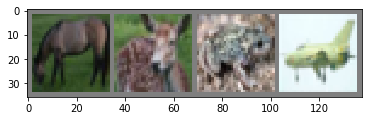

In [172]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# show images
imshow(torchvision.utils.make_grid(images))

In [173]:
# Compile swa

lr = 1e-3
momentum=0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
train_scheduler = CosineAnnealingLR
swa_scheduler = LambdaLR

swag.compile(lr, momentum, optimizer, loss_fn, train_scheduler, swa_scheduler)

In [174]:
# Fit swag
first_mom, second_mom, D = swag.fit(trainloader,
                                    train_epoch=2,
                                    swag_epoch=2)

Begin NN model training:
[1,  2000] loss: 2.212
[1,  4000] loss: 1.909
[1,  6000] loss: 1.679
[1,  8000] loss: 1.601
[1, 10000] loss: 1.523
[1, 12000] loss: 1.487
[2,  2000] loss: 1.415
[2,  4000] loss: 1.388
[2,  6000] loss: 1.367
[2,  8000] loss: 1.356
[2, 10000] loss: 1.321
[2, 12000] loss: 1.305

Begin SWAG training:
[1,  2000] loss: 1.233
[1,  4000] loss: 1.238
[1,  6000] loss: 1.200
[1,  8000] loss: 1.221
[1, 10000] loss: 1.216
[1, 12000] loss: 1.174
[2,  2000] loss: 1.126
[2,  4000] loss: 1.134
[2,  6000] loss: 1.110
[2,  8000] loss: 1.118
[2, 10000] loss: 1.107
[2, 12000] loss: 1.123


In [175]:
first_mom.shape, second_mom.shape, D.shape

((62006,), (62006,), (62006, 2))

In [91]:
# weight_sampler function test
# weights = swag.weight_sampler(first_mom[0:100], second_mom[0:100], D[0:100,:], S=1)
weights = swag.weight_sampler(first_mom, second_mom, D)

torch.Size([62006]) torch.Size([62006]) torch.Size([62006, 2]) torch.Size([62006])
torch.Size([62006])
torch.Size([62006])


# SWAG Testing

In [176]:
## Little Test
# Generate weight samples
S = 3
weight_samples = []
for i in range(S):
    samples = swag.weight_sampler(first_mom, second_mom, D)
    weight_samples.append(samples)

torch.Size([62006]) torch.Size([62006]) torch.Size([62006, 2]) torch.Size([62006])
torch.Size([62006])
torch.Size([62006])
torch.Size([62006]) torch.Size([62006]) torch.Size([62006, 2]) torch.Size([62006])
torch.Size([62006])
torch.Size([62006])
torch.Size([62006]) torch.Size([62006]) torch.Size([62006, 2]) torch.Size([62006])
torch.Size([62006])
torch.Size([62006])


In [177]:
# prepare test images
testiter = iter(testloader)
images, labels = testiter.next()

In [178]:
# Recreate new net with the sampled weights
prob = np.zeros((len(images),len(classes)))
for s, weight_param in enumerate(weight_samples):
    model_params = params_1d_to_weights(weight_param, swag.shape_lookup, swag.len_lookup)
    new_net = create_NN_with_weights(swag.NN_class, model_params)
    output = new_net.forward(images)
    softmax = torch.exp(output)
    prob = prob + list(softmax.detach().numpy()*1/S)
print(prob)
predictions = np.argmax(prob, axis=1)
print('Prediction: ',predictions)
print('Data: ',labels.numpy())

[[3.05099718e-01 5.04087821e-01 9.66486782e-01 1.66793470e+01
  4.70426597e-01 4.38742840e+00 2.36626256e+00 2.48704143e-01
  1.12928700e+00 2.13675059e-01]
 [1.90166416e+02 1.02218998e+02 1.66892152e-01 1.28835425e-01
  6.66920305e-03 1.09409674e-02 2.16453446e-02 1.01012054e-02
  1.84491058e+03 4.63665543e+01]
 [1.57662196e+01 1.89685804e+00 1.27785549e+00 6.56295627e-01
  2.46777013e-01 1.68516546e-01 1.89400468e-01 1.30718835e-01
  2.06042190e+01 2.00776261e+00]
 [8.59502583e+01 3.22283715e+00 1.27260074e+00 1.97158564e-01
  1.10717993e-01 1.73821880e-02 8.41987655e-02 1.37010328e-02
  1.89301178e+03 2.48792291e+00]]
Prediction:  [3 8 8 8]
Data:  [3 8 8 0]


In [179]:
# test the predict function
swag.predict(images,classes,first_mom,second_mom,D,S)

torch.Size([62006]) torch.Size([62006]) torch.Size([62006, 2]) torch.Size([62006])
torch.Size([62006])
torch.Size([62006])
torch.Size([62006]) torch.Size([62006]) torch.Size([62006, 2]) torch.Size([62006])
torch.Size([62006])
torch.Size([62006])
torch.Size([62006]) torch.Size([62006]) torch.Size([62006, 2]) torch.Size([62006])
torch.Size([62006])
torch.Size([62006])


array([3, 8, 8, 8])